In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,Conv2D,MaxPool2D,Flatten,GlobalAvgPool2D,concatenate,BatchNormalization,Activation,Add,ZeroPadding2D,Lambda
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# 类别数
num_classes = 17
# 批次大小
batch_size = 32
# 周期数
epochs = 100
# 图片大小
image_size = 224

In [3]:
# 训练集数据进行数据增强
train_datagen = ImageDataGenerator(
    rotation_range = 20,     # 随机旋转度数
    width_shift_range = 0.1, # 随机水平平移
    height_shift_range = 0.1,# 随机竖直平移
    rescale = 1/255,         # 数据归一化
    shear_range = 10,       # 随机错切变换
    zoom_range = 0.1,        # 随机放大
    horizontal_flip = True,  # 水平翻转
    brightness_range=(0.7, 1.3), # 亮度变化
    fill_mode = 'nearest',   # 填充方式
) 
# 测试集数据只需要归一化就可以
test_datagen = ImageDataGenerator(
    rescale = 1/255,         # 数据归一化
) 

In [4]:
# 训练集数据生成器，可以在训练时自动产生数据进行训练
# 从'data/train'获得训练集数据
# 获得数据后会把图片resize为image_size×image_size的大小
# generator每次会产生batch_size个数据
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(image_size,image_size),
    batch_size=batch_size,
    )

# 测试集数据生成器
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(image_size,image_size),
    batch_size=batch_size,
    )

Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


In [5]:
# 字典的键为17个文件夹的名字，值为对应的分类编号
train_generator.class_indices

{'flower0': 0,
 'flower1': 1,
 'flower10': 2,
 'flower11': 3,
 'flower12': 4,
 'flower13': 5,
 'flower14': 6,
 'flower15': 7,
 'flower16': 8,
 'flower2': 9,
 'flower3': 10,
 'flower4': 11,
 'flower5': 12,
 'flower6': 13,
 'flower7': 14,
 'flower8': 15,
 'flower9': 16}

In [6]:
# 定义分组卷积
# g_channels 每组的通道数
# groups 多少组
def grouped_convolution_block(init_x, strides, groups, g_channels):
    group_list = []
    # 分组进行卷积
    for c in range(groups):
        # 分组取出数据
        x = Lambda(lambda x: x[:, :, :, c*g_channels:(c+1)*g_channels])(init_x)
        # 分组进行卷积
        x = Conv2D(filters=g_channels,kernel_size=3,strides=strides,padding='same',use_bias=False)(x)
        # 存入list
        group_list.append(x)
    # 合并list中的数据
    group_merge = concatenate(group_list, axis=3)
    x = BatchNormalization(epsilon=1.001e-5)(group_merge)
    x = Activation('relu')(x)
    return x

# 定义残差单元
def block(x, filters, strides=1, groups=32, conv_shortcut=True): 
    # projection shortcut
    if conv_shortcut == True:
        shortcut = Conv2D(filters*2,kernel_size=1,strides=strides,padding='same')(x)
        # epsilon为BN公式中防止分母为零的值
        shortcut = BatchNormalization(epsilon=1.001e-5)(shortcut)
    else:
        # identity_shortcut
        shortcut = x
    # 3个卷积层
    x = Conv2D(filters=filters,kernel_size=1,strides=1,padding='same')(x)
    x = BatchNormalization(epsilon=1.001e-5)(x)
    x = Activation('relu')(x)
    # 计算每组的通道数
    g_channels = int(filters / groups) 
    # 进行分组卷积
    x = grouped_convolution_block(x, strides, groups, g_channels)
 
    x = Conv2D(filters=filters*2,kernel_size=1,strides=1,padding='same')(x)
    x = BatchNormalization(epsilon=1.001e-5)(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# 堆叠残差单元
def stack(x, filters, blocks, strides, groups=32):
    x = block(x, filters, strides=strides, groups=groups)
    for i in range(blocks):
        x = block(x, filters, groups=groups, conv_shortcut=False)
    return x
    
# 定义ResNeXt50
inputs = Input(shape=(image_size,image_size,3))
# 填充3圈0，填充后图像从224×224变成230×230
x = ZeroPadding2D((3, 3))(inputs)
x= Conv2D(filters=64,kernel_size=7,strides=2,padding='valid')(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
# 填充1圈0
x = ZeroPadding2D((1, 1))(x)
x = MaxPool2D(pool_size=3,strides=2,padding='valid')(x)
# 堆叠残差结构
# blocks表示堆叠数量
x = stack(x, filters=128, blocks=2, strides=1)
x = stack(x, filters=256, blocks=3, strides=2)
x = stack(x, filters=512, blocks=5, strides=2)
x = stack(x, filters=1024, blocks=2, strides=2)
# 根据特征图大小进行平均池化，池化后得到2维数据
x = GlobalAvgPool2D()(x)
x = Dense(num_classes, activation='softmax')(x)
# 定义模型
model = Model(inputs=inputs,outputs=x)

# 电脑配置不好的话不要运行summary或者plot_model
# model.summary()

In [7]:
# 学习率调节函数，逐渐减小学习率
def adjust_learning_rate(epoch):
    # 前40周期
    if epoch<=40:
        lr = 1e-4
    # 前40到80周期
    elif epoch>40 and epoch<=80:
        lr = 1e-5
    # 80到100周期
    else:
        lr = 1e-6
    return lr

In [8]:
# 定义优化器
adam = Adam(lr=1e-4)

# 定义学习率衰减策略
callbacks = []
callbacks.append(LearningRateScheduler(adjust_learning_rate))

# 定义优化器，loss function，训练过程中计算准确率
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

# Tensorflow2.1版本之前可以使用fit_generator训练模型
# history = model.fit_generator(train_generator,steps_per_epoch=len(train_generator),epochs=epochs,validation_data=test_generator,validation_steps=len(test_generator))

# Tensorflow2.1版本(包括2.1)之后可以直接使用fit训练模型
history = model.fit(x=train_generator,epochs=epochs,validation_data=test_generator,callbacks=callbacks)

W0317 22:57:29.930400 14964 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0317 22:57:30.075013 14964 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 34 steps, validate for 9 steps
Epoch 1/100
34/34 [==============================] - 37s 1s/step - loss: 2.8832 - accuracy: 0.0901 - val_loss: 2.9076 - val_accuracy: 0.0588
Epoch 2/100
34/34 [==============================] - 17s 490ms/step - loss: 2.4876 - accuracy: 0.1838 - val_loss: 3.1728 - val_accuracy: 0.0588
Epoch 3/100
34/34 [==============================] - 17s 489ms/step - loss: 2.2202 - accuracy: 0.2610 - val_loss: 3.7961 - val_accuracy: 0.0588
Epoch 4/100
34/34 [==============================] - 17s 489ms/step - loss: 2.1167 - accuracy: 0.2996 - val_loss: 5.4235 - val_accuracy: 0.0588
Epoch 5/100
34/34 [==============================] - 17s 489ms/step - loss: 1.9458 - accuracy: 0.3603 - val_loss: 4.2730 - val_accuracy: 0.0588
Epoch 6/100
34/34 [==============================] - 17s 490ms/step - loss: 1.8567 - accuracy: 0.3989 - val_loss: 5.0797 - val_accuracy: 0.0588
Epoch 7/100
34/34 [==============================] - 17s 490ms/step - loss: 1.7118 - accuracy: 0.4

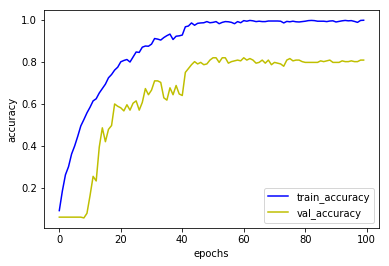

In [9]:
# 画出训练集准确率曲线图
plt.plot(np.arange(epochs),history.history['accuracy'],c='b',label='train_accuracy')
# 画出验证集准确率曲线图
plt.plot(np.arange(epochs),history.history['val_accuracy'],c='y',label='val_accuracy')
# 图例
plt.legend()
# x坐标描述
plt.xlabel('epochs')
# y坐标描述
plt.ylabel('accuracy')
# 显示图像
plt.show()
# 模型保存
model.save('ResNeXt50.h5')